In [2]:
##### IMPORTING DEPENDENCIES #####
# system tools and parse
import os 
import argparse
import warnings
warnings.filterwarnings("ignore")
# data tools
import pandas as pd
# tf tools
import tensorflow as tf
# image processsing
from tensorflow.keras.preprocessing.image import (ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
# layers
from tensorflow.keras.layers import (Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization)
# generic model object
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers import Adam, SGD
#scikit-learn
from sklearn.metrics import classification_report
import sklearn.model_selection as sk
# for plotting
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# import splitfolders

# splitfolders.ratio("fruits/train/train/", # The location of dataset
#                    output="fruits_v2", # The output location
#                    seed=42, # The number of seed
#                    ratio=(.7, .2, .1), # The ratio of splited dataset
#                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                    move=False # If you choose to move, turn this into True
#                    )

Copying files: 16854 files [00:16, 1001.56 files/s]


In [7]:
def setup_generators():
    # Parameters for loading data and images

    train_generator = ImageDataGenerator(horizontal_flip=True,
                                         rescale = 1./255,
                                         validation_split=0.2
                                         )
    
    test_generator = ImageDataGenerator(rescale=1./255)
    
    return train_generator, test_generator

train_generator, test_generator = setup_generators()

In [9]:
def setup_data(train_generator, test_generator):
    # Split the data into three categories.
    train_ds = train_generator.flow_from_directory(
        directory=os.path.join(os.getcwd(), "fruits_v2", "train"),
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42
    )
    
    val_ds = train_generator.flow_from_directory(
        directory=os.path.join(os.getcwd(), "fruits_v2", "val"),
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42
    )

    test_ds = test_generator.flow_from_directory(
        directory=os.path.join(os.getcwd(), "fruits_v2", "test"),
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = setup_data(train_generator, test_generator)

Found 11787 images belonging to 33 classes.
Found 3361 images belonging to 33 classes.
Found 1706 images belonging to 33 classes.


In [12]:
def model_setup():

    tf.keras.backend.clear_session()
    
    # load model without classifier layers
    model = VGG16(include_top=False, 
                pooling="avg",
                input_shape=(224, 224, 3),
                weights='imagenet')

    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    
    x = Flatten()(model.layers[-1].output)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(33, activation='softmax')(x)

    model = Model(inputs=model.inputs, outputs=outputs)

    # compile
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=10000,
        decay_rate=0.9)
    
    sgd = SGD(learning_rate=lr_schedule)

    model.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    print(model.summary())
    
    return model

model = model_setup()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [13]:
def train_model(model, train_ds, val_ds):
    history = model.fit_generator(train_ds,
                        validation_data = val_ds,
                        epochs=10
                        )
    
    return history

history = train_model(model, train_ds, val_ds)

Epoch 1/10
  3/369 [..............................] - ETA: 21:36 - loss: 3.7462 - accuracy: 0.0208

KeyboardInterrupt: 

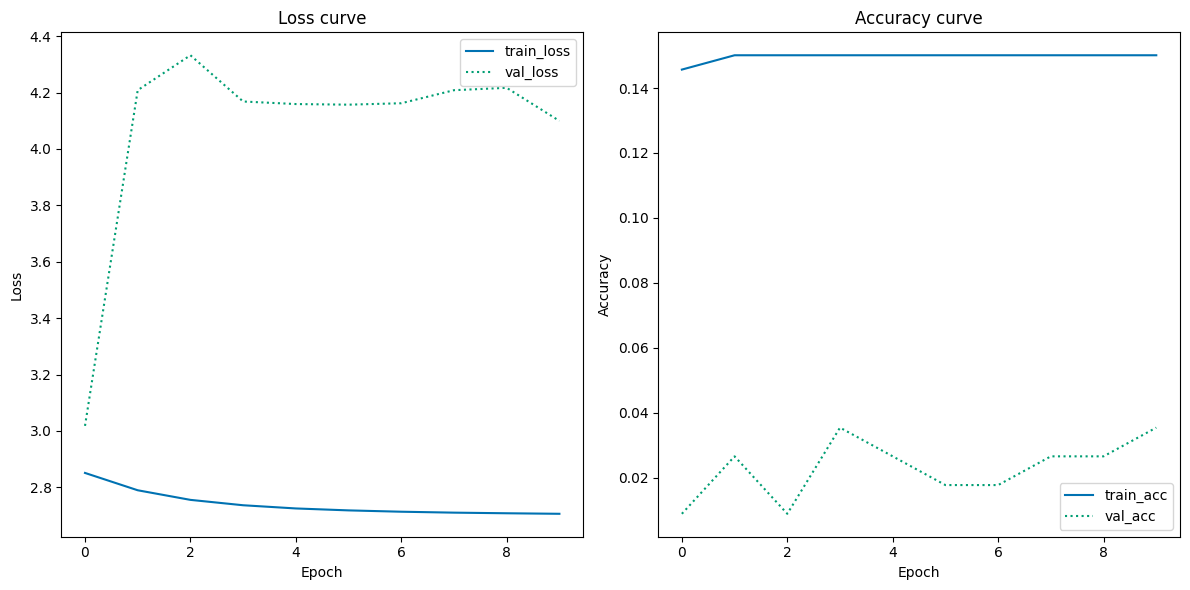

In [14]:
##### PLOTTING FUNCTION #####
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(os.getcwd(), "out", "cnn_pokemon.png"))

plot_history(history, 10)

In [ ]:
def make_predictions(model, test_ds):
    y_test = test_ds.

    y_pred = model.predict_generator(test_ds, steps=len(test_ds))

    y_pred = np.argmax(y_pred, axis=1)
    
    return y_test, y_pred

def print_report(y_test, y_pred, test_ds):
    # Get the classification report
    report = classification_report(y_test,
                                   y_pred,
                                   target_names = test_ds.class_indices.keys()
                                   )
    # Save the report
    with open(os.path.join(os.getcwd(), "out", "classification_report.txt"), "w") as f:
            f.write(report)
    # Print the report
    print(report)